In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from os import path, listdir
import numpy as np

In [2]:
dfs = []
dirs = sorted(listdir('.'))
print(dirs)
dfs = [pd.read_csv(file, comment='#') for file in dirs if file[-3:] == 'csv']

['Flight_data_GS_Andenes_complete.csv', 'TUMOR_2024_04_24_13_20_43.csv', 'TUMOR_2024_04_24_14_32_51.csv', 'TUMOR_2024_04_24_14_47_40.csv', 'process_andenes.ipynb']


In [3]:
df = pd.concat(dfs)

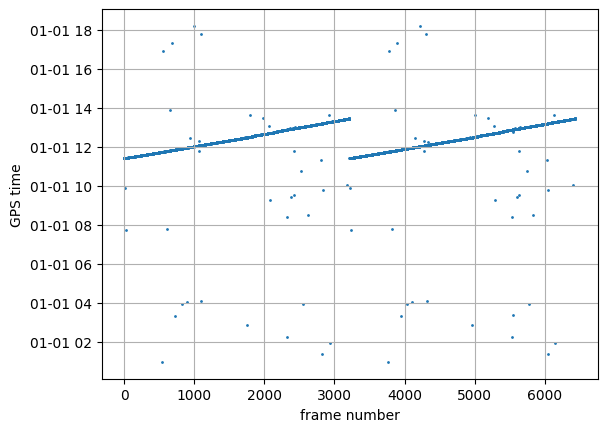

In [4]:
time = pd.to_datetime(df[f'time_GPS'], format='%H:%M:%S')
plt.scatter(np.arange(time.shape[0]), time, s=1)
plt.ylabel('GPS time')
plt.xlabel('frame number')
plt.grid()


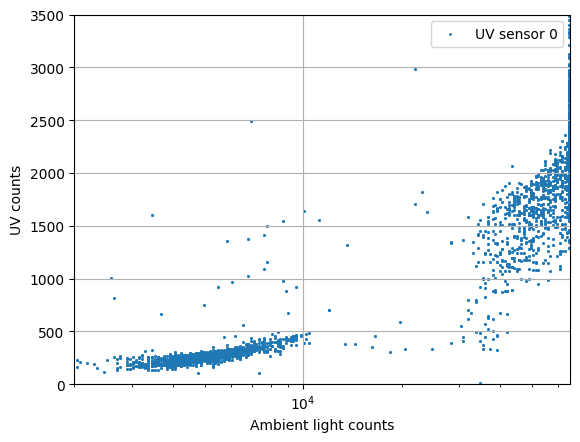

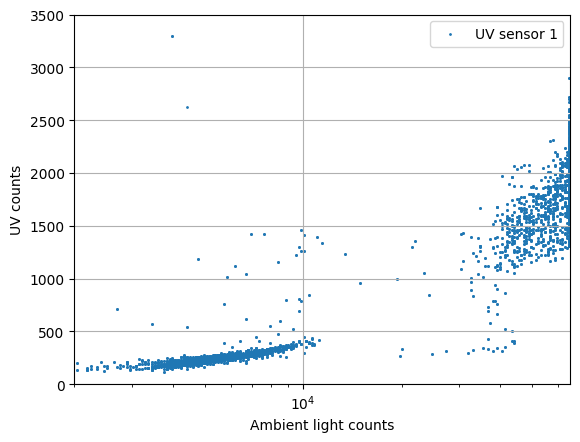

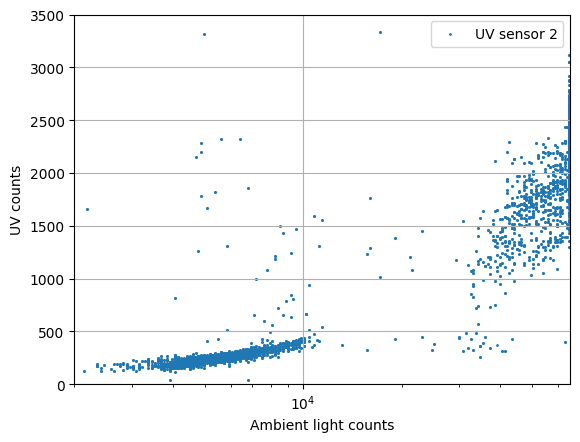

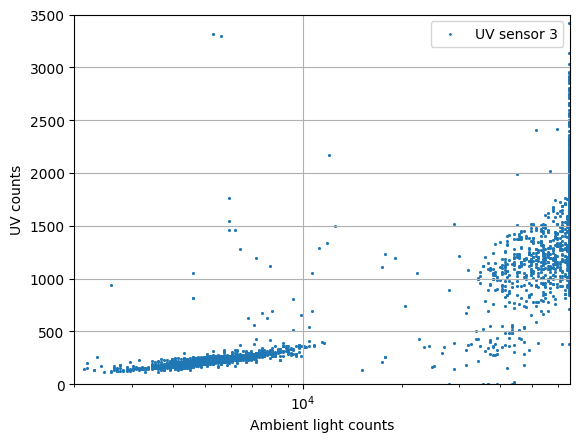

In [5]:
for i in range(4):
    plt.scatter(df[f'AL_{i}'], df[f'UV_{i}'], s=1, label=f'UV sensor {i}')
    plt.ylim((0, 3500))
    plt.xlim((2000, 65535))
    plt.xlabel('Ambient light counts')
    plt.ylabel('UV counts')
    plt.xscale('log')
    plt.legend()
    plt.grid()
    plt.show()

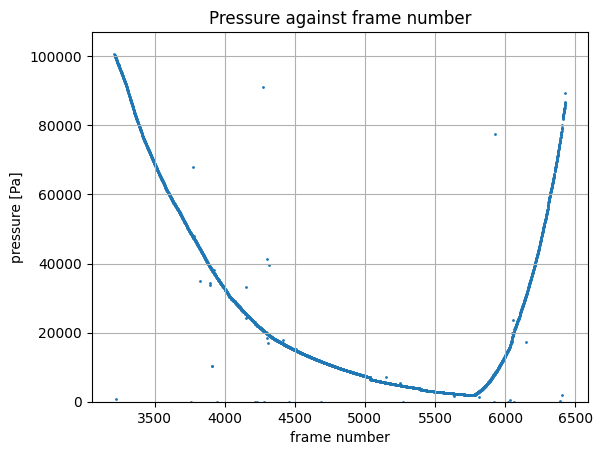

In [6]:
p = df['pressure'].to_numpy()
p = np.exp(p / 5500) - 1
plt.scatter(np.arange(p.shape[0]), p, s=1)
plt.ylim((0, 107000))
plt.ylabel('pressure [Pa]')
plt.xlabel('frame number')
plt.title('Pressure against frame number')
plt.grid()

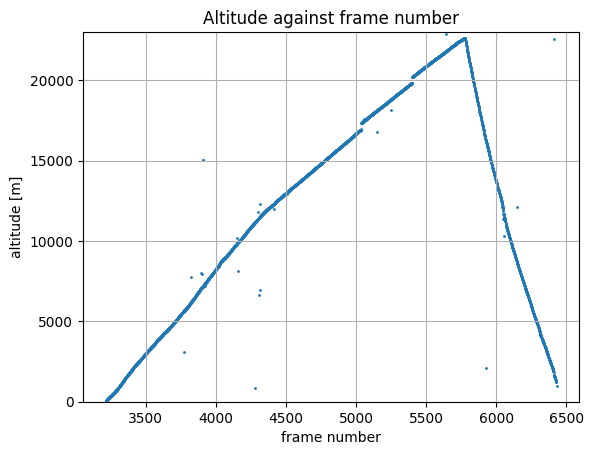

In [7]:
T0 = 277.3
p0 = 101000
alpha = -0.0065
R = 287.06
g0 = 9.81

h = T0 / alpha * ((p / p0) ** (-alpha * R / g0) - 1)
plt.scatter(np.arange(h.shape[0]), h, s=1)
plt.ylim((0, 23000))
plt.xlabel('frame number')
plt.ylabel('altitude [m]')
plt.title('Altitude against frame number')
plt.grid()

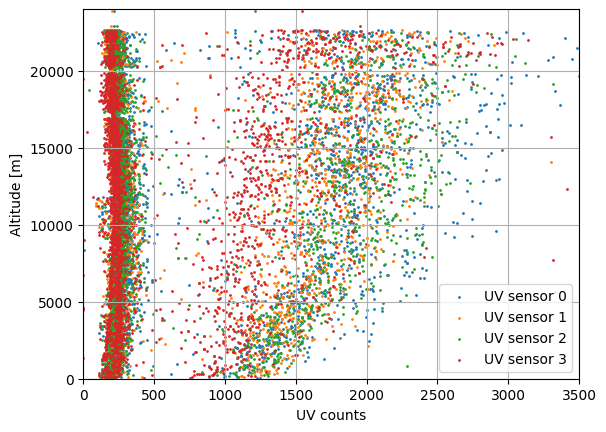

In [8]:
for i in range(4):
    plt.scatter(df[f'UV_{i}'], h, s=1, label=f'UV sensor {i}')
plt.xlim((0, 3500))
plt.ylim((0, 24000))
plt.ylabel('Altitude [m]')
plt.xlabel('UV counts')
plt.legend()
plt.grid()

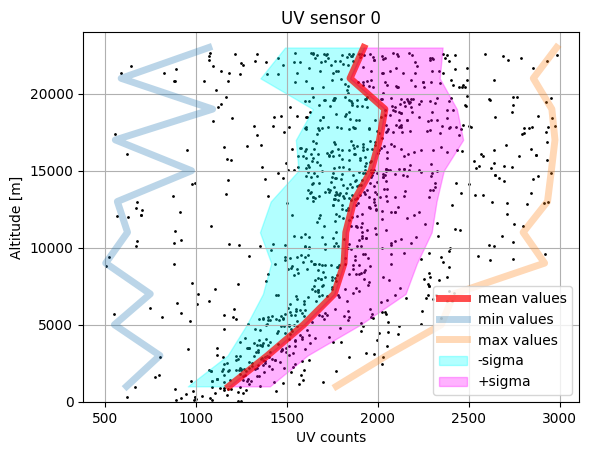

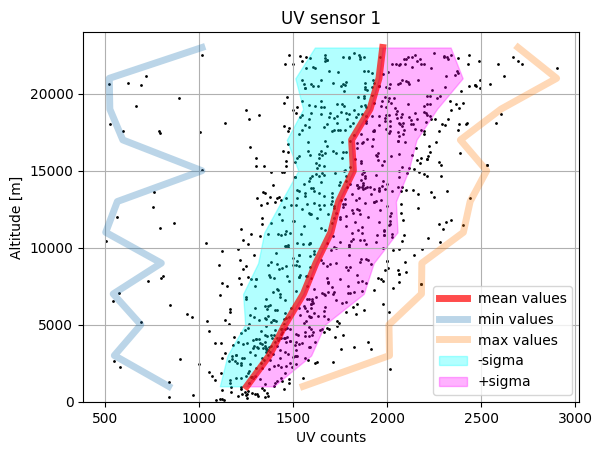

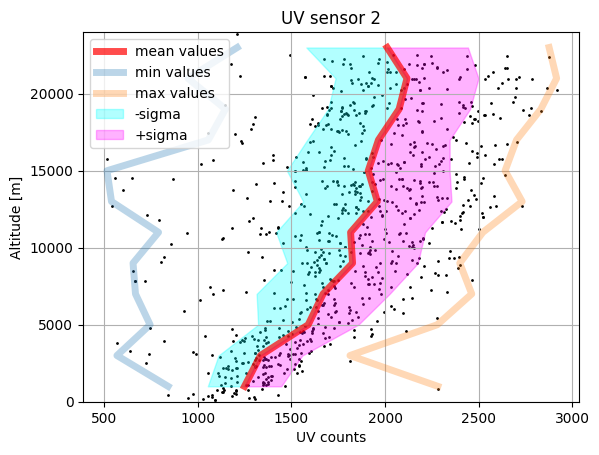

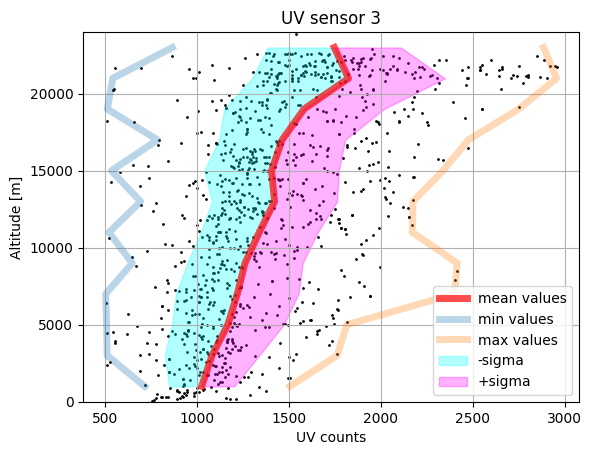

In [9]:
for i in range(4):
    uvs = df[f'UV_{i}'].to_numpy()
    mask = (uvs>500)&(uvs<3000)
    uvs = uvs[mask]
    ys = h[mask]
    plt.scatter(uvs, ys, s=1, c='k')
    plt.ylim((0, 24000))
    resolution = 2_000
    n_buckets = 12
    bucket_altitudes = [(i + 0.5) * resolution for i in range(n_buckets)]
    buckets = [uvs[(ys>resolution * i)&(ys<resolution * (i + 1))] for i in range(n_buckets)]
    medians = np.array([bucket.mean() for bucket in buckets])
    mins = np.array([bucket.min() for bucket in buckets])
    maxs = np.array([bucket.max() for bucket in buckets])
    sigmas = np.array([bucket.std() for bucket in buckets])
    plt.plot(medians, bucket_altitudes, label='mean values', linewidth=5, alpha=0.7, color='red')
    plt.plot(mins, bucket_altitudes, label='min values', linewidth=5, alpha=0.3)
    plt.plot(maxs, bucket_altitudes, label='max values', linewidth=5, alpha=0.3)
    plt.fill_betweenx(bucket_altitudes, medians, medians - sigmas, label='-sigma', alpha=0.3, color='cyan')
    plt.fill_betweenx(bucket_altitudes, medians + sigmas, medians, label='+sigma', alpha=0.3, color='magenta')
    plt.legend()
    plt.title(f'UV sensor {i}')
    plt.ylabel('Altitude [m]')
    plt.xlabel('UV counts')
    plt.grid()
    plt.show()

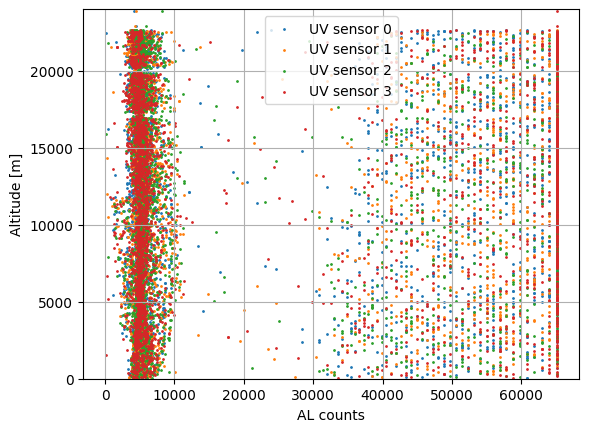

In [10]:
for i in range(4):
    plt.scatter(df[f'AL_{i}'], h, s=1, label=f'UV sensor {i}')
# plt.xlim((0, 3500))
plt.ylim((0, 24000))
plt.ylabel('Altitude [m]')
plt.xlabel('AL counts')
plt.legend()
plt.grid()

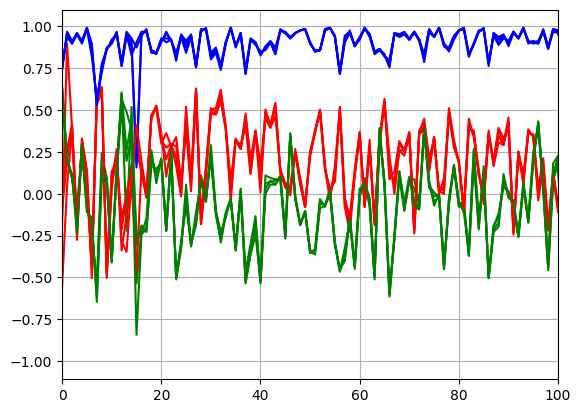

In [11]:
xs = np.arange(df.shape[0])
colours = {'x': 'r', 'y': 'g', 'z': 'b'}
for i in range(4):
    for d in ['x', 'y', 'z']:
        plt.plot(xs, df[f'M{d}_{i}'].to_numpy(), label=f'M{d}', color=colours[d])

plt.xlim((0, 100))
plt.grid()

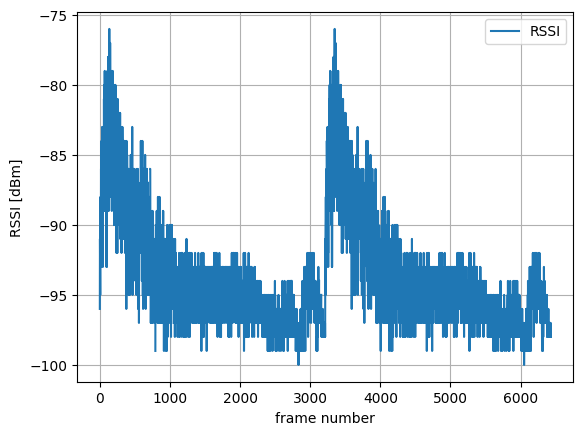

In [12]:
xs = np.arange(df.shape[0])
plt.plot(xs, df['RSSI'], label='RSSI')
plt.ylabel('RSSI [dBm]')
plt.xlabel('frame number')
plt.legend()
plt.grid()

Text(0.5, 0.98, 'UV/AL ratio for sun-facing measurements')

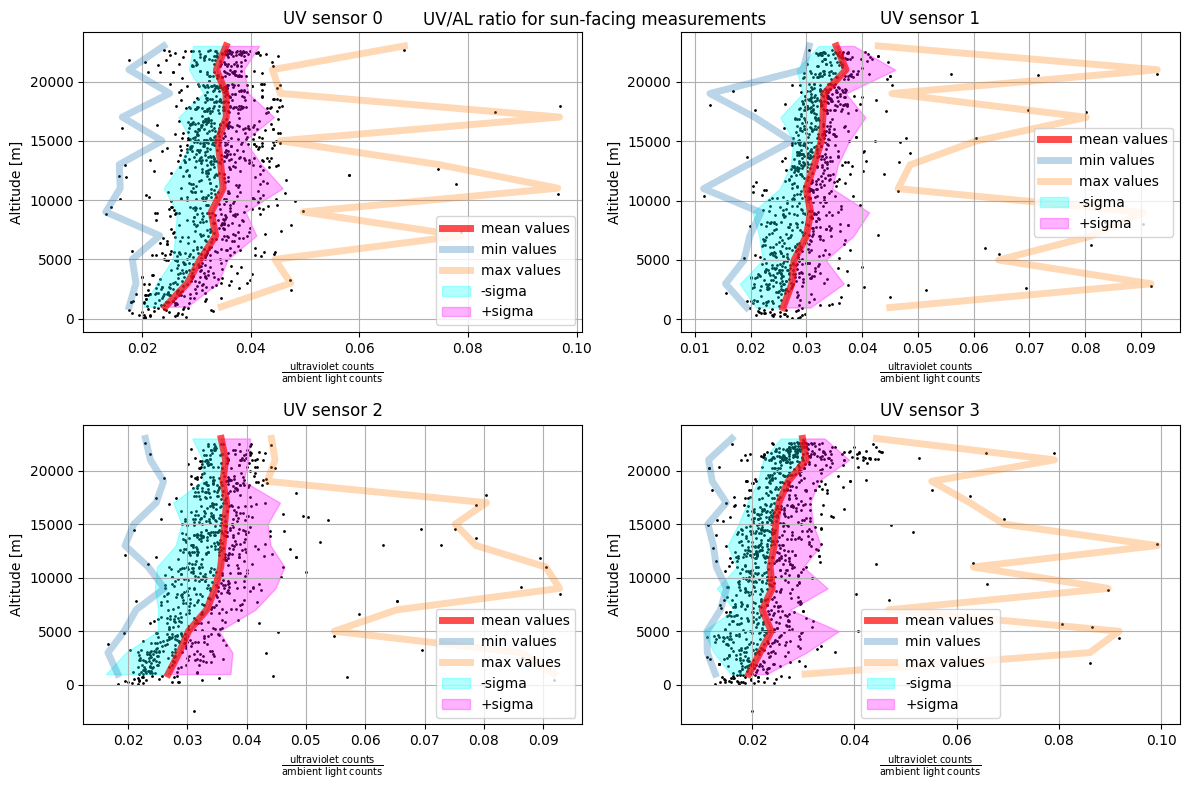

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

for i in range(4):
    x, y = i // 2, i % 2
    ax = axes[x, y]
    uvs = df[f'UV_{i}'].to_numpy()
    als = df[f'AL_{i}'].to_numpy()
    mask = (uvs>500)&(uvs<3000)&(uvs/als<0.1)&(h<23_000)
    uvs = uvs[mask]
    als = als[mask]
    ratios = uvs / als
    ys = h[mask]
    ax.scatter(uvs / als, ys, s=1, c='k')
    max_altitude = 24_000
    # plt.xlim((0, 0.06))
    n_buckets = 12
    resolution = max_altitude / n_buckets
    bucket_altitudes = [(i + 0.5) * resolution for i in range(n_buckets)]
    buckets = [ratios[(ys>resolution * i)&(ys<resolution * (i + 1))] for i in range(n_buckets)]
    medians = np.array([bucket.mean() for bucket in buckets])
    mins = np.array([bucket.min() for bucket in buckets])
    maxs = np.array([bucket.max() for bucket in buckets])
    sigmas = np.array([bucket.std() for bucket in buckets])
    ax.plot(medians, bucket_altitudes, label='mean values', linewidth=5, alpha=0.7, color='red')
    ax.plot(mins, bucket_altitudes, label='min values', linewidth=5, alpha=0.3)
    ax.plot(maxs, bucket_altitudes, label='max values', linewidth=5, alpha=0.3)
    ax.fill_betweenx(bucket_altitudes, medians, medians - sigmas, label='-sigma', alpha=0.3, color='cyan')
    ax.fill_betweenx(bucket_altitudes, medians + sigmas, medians, label='+sigma', alpha=0.3, color='magenta')
    ax.legend()
    ax.set_title(f'UV sensor {i}')
    ax.set_ylabel('Altitude [m]')
    ax.set_xlabel(r'$\frac{\text{ultraviolet counts}}{\text{ambient light counts}}$')
    ax.grid()
fig.tight_layout()
fig.suptitle('UV/AL ratio for sun-facing measurements')

Text(0.5, 0.98, 'UV/AL ratio for no sunlight measurements')

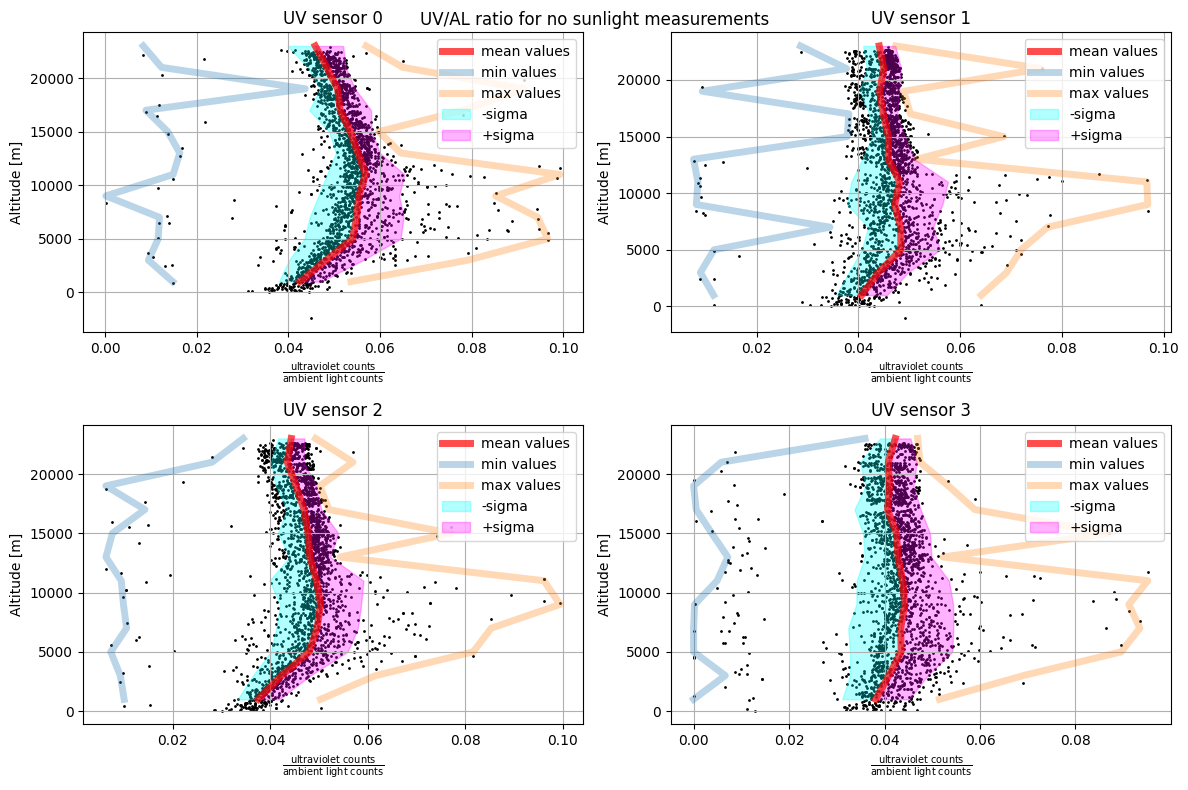

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

for i in range(4):
    x, y = i // 2, i % 2
    ax = axes[x, y]
    uvs = df[f'UV_{i}'].to_numpy()
    als = df[f'AL_{i}'].to_numpy()
    mask = (uvs<500)&(uvs/als<0.1)&(h<23_000)
    uvs = uvs[mask]
    als = als[mask]
    ratios = uvs / als
    ys = h[mask]
    ax.scatter(uvs / als, ys, s=1, c='k')
    max_altitude = 24_000
    # plt.xlim((0, 0.06))
    n_buckets = 12
    resolution = max_altitude / n_buckets
    bucket_altitudes = [(i + 0.5) * resolution for i in range(n_buckets)]
    buckets = [ratios[(ys>resolution * i)&(ys<resolution * (i + 1))] for i in range(n_buckets)]
    medians = np.array([bucket.mean() for bucket in buckets])
    mins = np.array([bucket.min() for bucket in buckets])
    maxs = np.array([bucket.max() for bucket in buckets])
    sigmas = np.array([bucket.std() for bucket in buckets])
    ax.plot(medians, bucket_altitudes, label='mean values', linewidth=5, alpha=0.7, color='red')
    ax.plot(mins, bucket_altitudes, label='min values', linewidth=5, alpha=0.3)
    ax.plot(maxs, bucket_altitudes, label='max values', linewidth=5, alpha=0.3)
    ax.fill_betweenx(bucket_altitudes, medians, medians - sigmas, label='-sigma', alpha=0.3, color='cyan')
    ax.fill_betweenx(bucket_altitudes, medians + sigmas, medians, label='+sigma', alpha=0.3, color='magenta')
    ax.legend()
    ax.set_title(f'UV sensor {i}')
    ax.set_ylabel('Altitude [m]')
    ax.set_xlabel(r'$\frac{\text{ultraviolet counts}}{\text{ambient light counts}}$')
    ax.grid()
fig.tight_layout()
fig.suptitle('UV/AL ratio for no sunlight measurements')

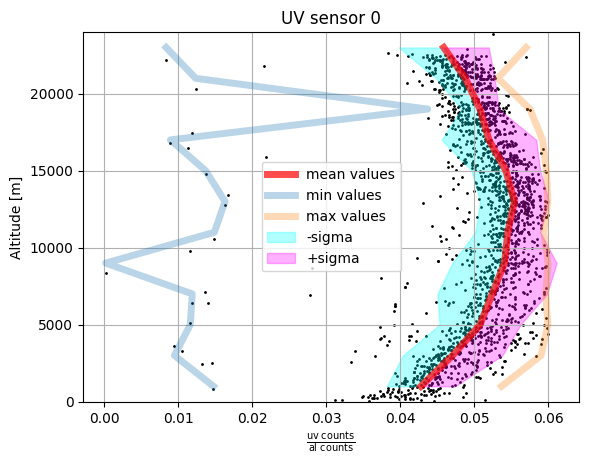

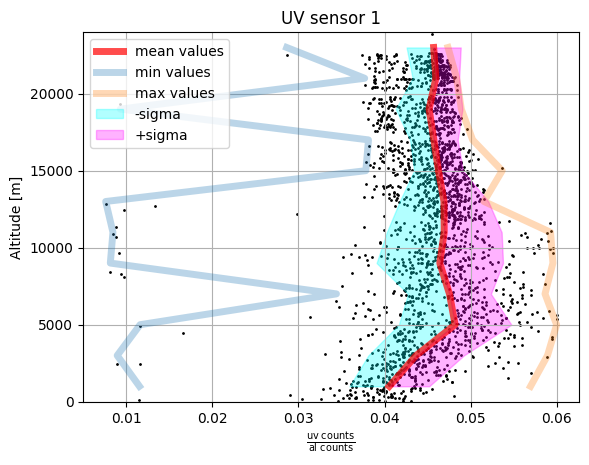

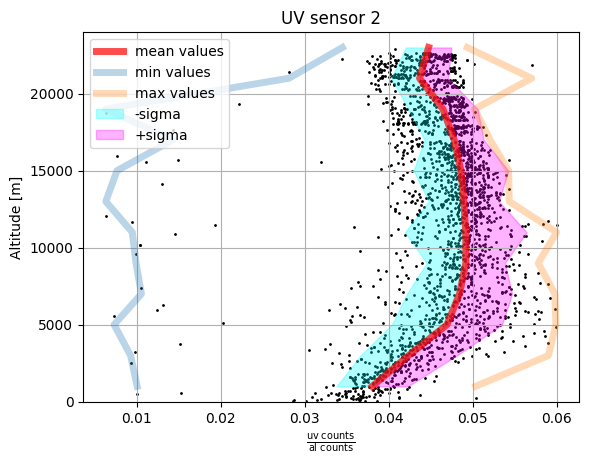

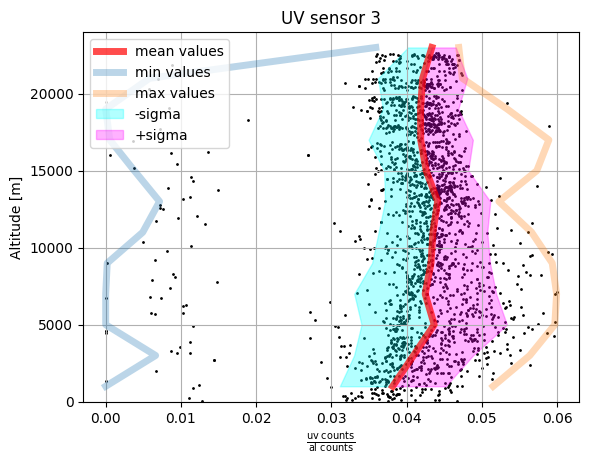

In [15]:
for i in range(4):
    uvs = df[f'UV_{i}'].to_numpy()
    als = df[f'AL_{i}'].to_numpy()
    mask = (uvs<500)&(uvs/als<0.06)
    uvs = uvs[mask]
    als = als[mask]
    ratios = uvs / als
    ys = h[mask]
    plt.scatter(uvs / als, ys, s=1, c='k')
    max_altitude = 24_000
    plt.ylim((0, max_altitude))
    # plt.xlim((0, 0.06))
    n_buckets = 12
    resolution = max_altitude / n_buckets
    bucket_altitudes = [(i + 0.5) * resolution for i in range(n_buckets)]
    buckets = [ratios[(ys>resolution * i)&(ys<resolution * (i + 1))] for i in range(n_buckets)]
    medians = np.array([np.median(bucket) for bucket in buckets])
    mins = np.array([bucket.min() for bucket in buckets])
    maxs = np.array([bucket.max() for bucket in buckets])
    sigmas = np.array([bucket.std() for bucket in buckets])
    plt.plot(medians, bucket_altitudes, label='mean values', linewidth=5, alpha=0.7, color='red')
    plt.plot(mins, bucket_altitudes, label='min values', linewidth=5, alpha=0.3)
    plt.plot(maxs, bucket_altitudes, label='max values', linewidth=5, alpha=0.3)
    plt.fill_betweenx(bucket_altitudes, medians, medians - sigmas, label='-sigma', alpha=0.3, color='cyan')
    plt.fill_betweenx(bucket_altitudes, medians + sigmas, medians, label='+sigma', alpha=0.3, color='magenta')
    plt.legend()
    plt.title(f'UV sensor {i}')
    plt.ylabel('Altitude [m]')
    plt.xlabel(r'$\frac{\text{uv counts}}{\text{al counts}}$')
    plt.grid()
    plt.show()

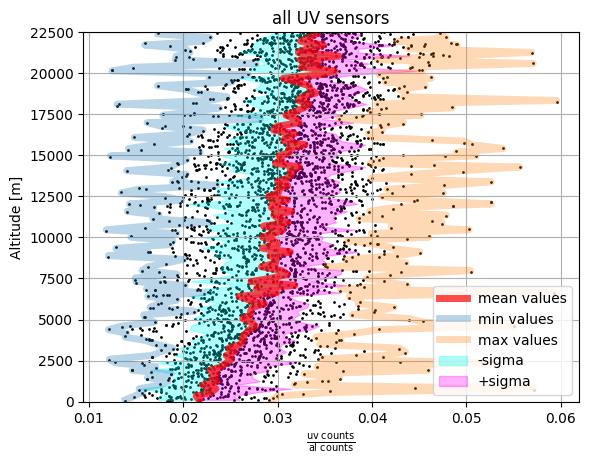

In [16]:


uvs = [df[f'UV_{i}'].to_numpy() for i in range(4)]
als = [df[f'AL_{i}'].to_numpy() for i in range(4)]
hs = [h for i in range(4)]

uv_all_average = 0
al_all_average = 0
for i in range(4):
    uv_average = uvs[i][uvs[i]<400].mean()
    al_average = als[i][als[i]<15000].mean()
    mask = (uvs[i]>500)&(uvs[i]<3000)&(uvs[i]/als[i]<0.06)
    # mask = (uvs[i]<500)&(uvs[i]/als[i]<0.1)
    uvs[i] = uvs[i] / uv_average
    uv_all_average += uv_average
    als[i] = als[i] / al_average
    al_all_average += al_average
    uvs[i] = uvs[i][mask]
    als[i] = als[i][mask]
    hs[i] = hs[i][mask]

uvs = np.concatenate(uvs) * uv_all_average
als = np.concatenate(als) * al_all_average
ys = np.concatenate(hs)

ratios = uvs / als

plt.scatter(ratios, ys, s=1, c='k')
max_altitude = 22_500
plt.ylim((0, max_altitude))
# plt.xlim((0, 0.06))
n_buckets = 100
resolution = max_altitude / n_buckets
bucket_altitudes = [(i + 0.5) * resolution for i in range(n_buckets)]
buckets = [ratios[(ys>resolution * i)&(ys<resolution * (i + 1))] for i in range(n_buckets)]
medians = np.array([np.median(bucket) for bucket in buckets])
mins = np.array([bucket.min() for bucket in buckets])
maxs = np.array([bucket.max() for bucket in buckets])
sigmas = np.array([bucket.std() for bucket in buckets])
plt.plot(medians, bucket_altitudes, label='mean values', linewidth=5, alpha=0.7, color='red')
plt.plot(mins, bucket_altitudes, label='min values', linewidth=5, alpha=0.3)
plt.plot(maxs, bucket_altitudes, label='max values', linewidth=5, alpha=0.3)
plt.fill_betweenx(bucket_altitudes, medians, medians - sigmas, label='-sigma', alpha=0.3, color='cyan')
plt.fill_betweenx(bucket_altitudes, medians + sigmas, medians, label='+sigma', alpha=0.3, color='magenta')
plt.legend()
plt.title(f'all UV sensors')
plt.ylabel('Altitude [m]')
plt.xlabel(r'$\frac{\text{uv counts}}{\text{al counts}}$')
plt.grid()
plt.show()

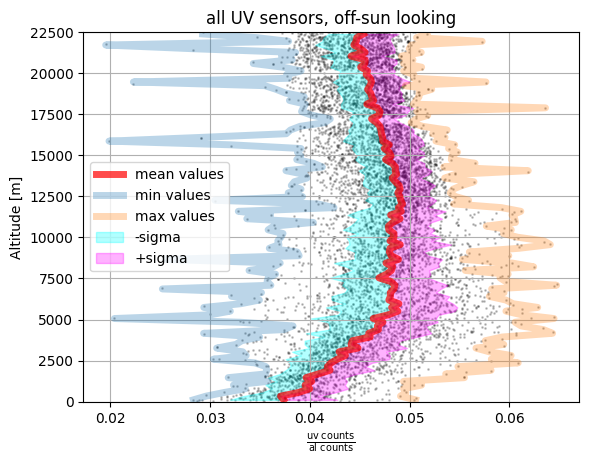

In [17]:
uvs = [df[f'UV_{i}'].to_numpy() for i in range(4)]
als = [df[f'AL_{i}'].to_numpy() for i in range(4)]
hs = [h for i in range(4)]

uv_all_average = 0
al_all_average = 0
for i in range(4):
    uv_average = uvs[i][uvs[i]<400].mean()
    al_average = als[i][als[i]<15000].mean()
    mask = (uvs[i]<500)&(uvs[i]/als[i]<0.06)&(uvs[i]/als[i]>0.02)
    # mask = (uvs[i]<500)&(uvs[i]/als[i]<0.1)
    uvs[i] = uvs[i] / uv_average
    uv_all_average += uv_average
    als[i] = als[i] / al_average
    al_all_average += al_average
    uvs[i] = uvs[i][mask]
    als[i] = als[i][mask]
    hs[i] = hs[i][mask]

uvs = np.concatenate(uvs) * uv_all_average
als = np.concatenate(als) * al_all_average
ys = np.concatenate(hs)

ratios = uvs/ als

plt.scatter(ratios, ys, s=1, c='k', alpha=0.2)
max_altitude = 22_500
plt.ylim((0, max_altitude))
# plt.xlim((0, 0.06))
n_buckets = 100
resolution = max_altitude / n_buckets
bucket_altitudes = [(i + 0.5) * resolution for i in range(n_buckets)]
buckets = [ratios[(ys>resolution * i)&(ys<resolution * (i + 1))] for i in range(n_buckets)]
medians = np.array([np.median(bucket) for bucket in buckets])
mins = np.array([bucket.min() for bucket in buckets])
maxs = np.array([bucket.max() for bucket in buckets])
sigmas = np.array([bucket.std() for bucket in buckets])
plt.plot(medians, bucket_altitudes, label='mean values', linewidth=5, alpha=0.7, color='red')
plt.plot(mins, bucket_altitudes, label='min values', linewidth=5, alpha=0.3)
plt.plot(maxs, bucket_altitudes, label='max values', linewidth=5, alpha=0.3)
plt.fill_betweenx(bucket_altitudes, medians, medians - sigmas, label='-sigma', alpha=0.3, color='cyan')
plt.fill_betweenx(bucket_altitudes, medians + sigmas, medians, label='+sigma', alpha=0.3, color='magenta')
plt.legend()
plt.title(f'all UV sensors, off-sun looking')
plt.ylabel('Altitude [m]')
plt.xlabel(r'$\frac{\text{uv counts}}{\text{al counts}}$')
plt.grid()
plt.show()

In [18]:
mxs = np.array([df[f'Mx_{i}'].to_numpy() for i in range(4)]).T.reshape(df.shape[0] * 4)
mys = np.array([df[f'My_{i}'].to_numpy() for i in range(4)]).T.reshape(df.shape[0] * 4)
mzs = np.array([df[f'Mz_{i}'].to_numpy() for i in range(4)]).T.reshape(df.shape[0] * 4)

(0.0, 100.0)

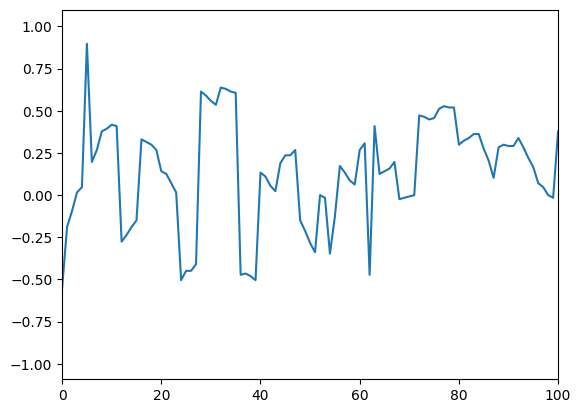

In [19]:
plt.plot(np.arange(mxs.shape[0]), mxs)
plt.xlim((0, 100))

Text(0, 0.5, 'Altitude [m]')

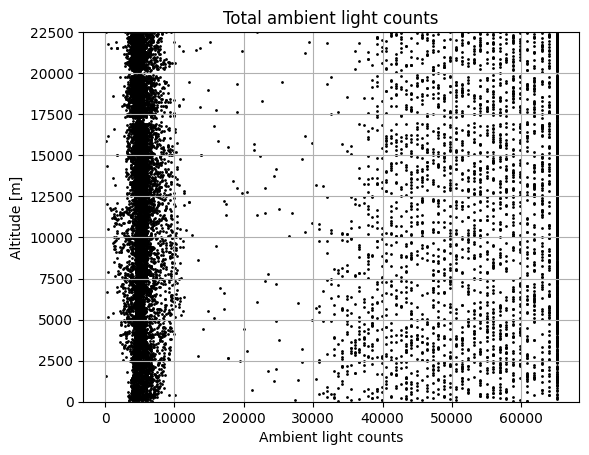

In [20]:
als = [df[f'AL_{i}'].to_numpy() for i in range(4)]
hs = [h for i in range(4)]

als = np.concatenate(als)
ys = np.concatenate(hs)


plt.scatter(als, ys, s=1, c='k')
max_altitude = 22_500
plt.ylim((0, max_altitude))
plt.title('Total ambient light counts')
plt.xlabel('Ambient light counts')
plt.grid()
plt.ylabel('Altitude [m]')

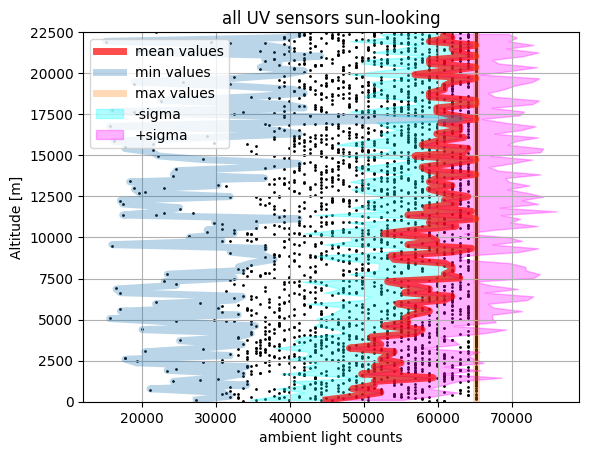

In [21]:
als = [df[f'AL_{i}'].to_numpy() for i in range(4)]
hs = [h for i in range(4)]

uv_all_average = 0
al_all_average = 0
for i in range(4):
    mask = als[i] > 1.5e4
    als[i] = als[i][mask]
    hs[i] = hs[i][mask]


als = np.concatenate(als)
ys = np.concatenate(hs)

ratios = als

plt.scatter(ratios, ys, s=1, c='k')
max_altitude = 22_500
plt.ylim((0, max_altitude))
# plt.xlim((0, 0.06))
n_buckets = 100
resolution = max_altitude / n_buckets
bucket_altitudes = [(i + 0.5) * resolution for i in range(n_buckets)]
buckets = [ratios[(ys>resolution * i)&(ys<resolution * (i + 1))] for i in range(n_buckets)]
medians = np.array([np.median(bucket) for bucket in buckets])
mins = np.array([bucket.min() for bucket in buckets])
maxs = np.array([bucket.max() for bucket in buckets])
sigmas = np.array([bucket.std() for bucket in buckets])
plt.plot(medians, bucket_altitudes, label='mean values', linewidth=5, alpha=0.7, color='red')
plt.plot(mins, bucket_altitudes, label='min values', linewidth=5, alpha=0.3)
plt.plot(maxs, bucket_altitudes, label='max values', linewidth=5, alpha=0.3)
plt.fill_betweenx(bucket_altitudes, medians, medians - sigmas, label='-sigma', alpha=0.3, color='cyan')
plt.fill_betweenx(bucket_altitudes, medians + sigmas, medians, label='+sigma', alpha=0.3, color='magenta')
plt.legend()
plt.title(f'all UV sensors sun-looking')
plt.ylabel('Altitude [m]')
plt.xlabel(r'ambient light counts')
plt.grid()
plt.show()

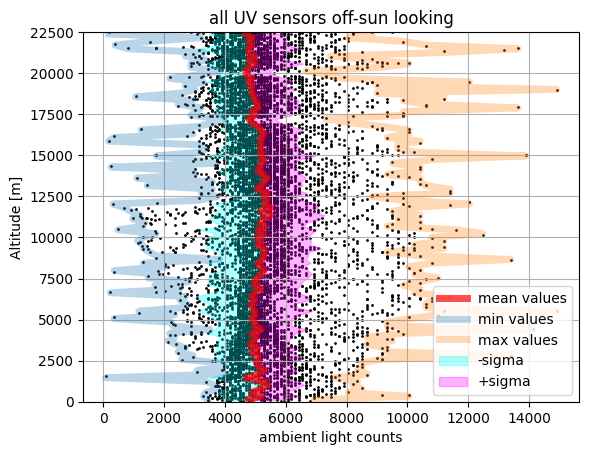

In [22]:
als = [df[f'AL_{i}'].to_numpy() for i in range(4)]
hs = [h for i in range(4)]

uv_all_average = 0
al_all_average = 0
for i in range(4):
    mask = als[i] < 1.5e4
    als[i] = als[i][mask]
    hs[i] = hs[i][mask]


als = np.concatenate(als)
ys = np.concatenate(hs)

ratios = als

plt.scatter(ratios, ys, s=1, c='k')
max_altitude = 22_500
plt.ylim((0, max_altitude))
# plt.xlim((0, 0.06))
n_buckets = 100
resolution = max_altitude / n_buckets
bucket_altitudes = [(i + 0.5) * resolution for i in range(n_buckets)]
buckets = [ratios[(ys>resolution * i)&(ys<resolution * (i + 1))] for i in range(n_buckets)]
medians = np.array([np.median(bucket) for bucket in buckets])
mins = np.array([bucket.min() for bucket in buckets])
maxs = np.array([bucket.max() for bucket in buckets])
sigmas = np.array([bucket.std() for bucket in buckets])
plt.plot(medians, bucket_altitudes, label='mean values', linewidth=5, alpha=0.7, color='red')
plt.plot(mins, bucket_altitudes, label='min values', linewidth=5, alpha=0.3)
plt.plot(maxs, bucket_altitudes, label='max values', linewidth=5, alpha=0.3)
plt.fill_betweenx(bucket_altitudes, medians, medians - sigmas, label='-sigma', alpha=0.3, color='cyan')
plt.fill_betweenx(bucket_altitudes, medians + sigmas, medians, label='+sigma', alpha=0.3, color='magenta')
plt.legend()
plt.title(f'all UV sensors off-sun looking')
plt.ylabel('Altitude [m]')
plt.xlabel(r'ambient light counts')
plt.grid()
plt.show()